In [0]:
from pyspark.sql import SparkSession

# Iniciar a sessão do Spark
spark = SparkSession.builder \
    .appName("Carregar Arquivo CSV") \
    .getOrCreate()

# Definir o caminho do arquivo CSV
file_path = "/FileStore/tables/sales_dataset.csv"

# Carregar o arquivo CSV em um DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Exibir as primeiras linhas do DataFrame
df.show()

+----------+----------+-------------------+--------+-----+-----+------------------+------+
|      Date|   Product|           Category|Quantity|Price|Total|          Customer|Region|
+----------+----------+-------------------+--------+-----+-----+------------------+------+
|2020-09-17|Headphones|Categoria Incorreta|      -4| -150|  600|      Benjamin Fox|   Sul|
|2023-11-02|Headphones|Categoria Incorreta|      -3| -150|  450|       Jill Farley| Leste|
|2023-05-14|    Tablet|Categoria Incorreta|      -2| -500| 1000|   Alexandra Nixon| Leste|
|2021-03-31|    Laptop|Categoria Incorreta|      -3|-1200| 3600|   Patricia Nguyen|   Sul|
|2022-03-21|Smartphone|        Eletrônicos|       3|  800| 2400|       Mark Newman| Norte|
|2022-11-10|Headphones|Categoria Incorreta|      -5| -150|  750|     Jeremy Foster|   Sul|
|2021-03-25|    Laptop|        Eletrônicos|       5| 1200| 6000|  Steven Maldonado| Leste|
|2021-02-14|Smartwatch|        Eletrônicos|       1|  300|  300|        Casey Lowe|   Sul|

In [0]:
from pyspark.sql.functions import col, regexp_replace, to_date, when
from pyspark.sql.types import StringType, IntegerType, FloatType

# Convertendo a coluna 'Date' para o tipo data
df = df.withColumn("Date", to_date(col("Date")))

# Tratamento de valores nulos
df = df.fillna(0)  # Preenchendo valores nulos com 0

# Aplicando regex simples na coluna 'Category'
df = df.withColumn("Category", when(col("Category") != "Eletrônicos", "Eletrônicos").otherwise(col("Category")))

# Garantindo que na coluna 'Quantity' não tenha números negativos ou zero
df = df.withColumn("Quantity", when(col("Quantity") <= 0, 1).otherwise(col("Quantity")))

# Garantindo que na coluna 'Price' não tenha números negativos
df = df.withColumn("Price", when(col("Price") < 0, col("Price") * -1).otherwise(col("Price")))

# Ajustando os tipos de dados
df = df.withColumn("Product", col("Product").cast(StringType()))
df = df.withColumn("Category", col("Category").cast(StringType()))
df = df.withColumn("Quantity", col("Quantity").cast(IntegerType()))
df = df.withColumn("Price", col("Price").cast(FloatType()))
df = df.withColumn("Total", col("Total").cast(FloatType()))
df = df.withColumn("Customer", col("Customer").cast(StringType()))
df = df.withColumn("Region", col("Region").cast(StringType()))

# Exibindo o dataframe
df.show()

+----------+----------+-----------+--------+------+------+------------------+------+
|      Date|   Product|   Category|Quantity| Price| Total|          Customer|Region|
+----------+----------+-----------+--------+------+------+------------------+------+
|2020-09-17|Headphones|Eletrônicos|       1| 150.0| 600.0|      Benjamin Fox|   Sul|
|2023-11-02|Headphones|Eletrônicos|       1| 150.0| 450.0|       Jill Farley| Leste|
|2023-05-14|    Tablet|Eletrônicos|       1| 500.0|1000.0|   Alexandra Nixon| Leste|
|2021-03-31|    Laptop|Eletrônicos|       1|1200.0|3600.0|   Patricia Nguyen|   Sul|
|2022-03-21|Smartphone|Eletrônicos|       3| 800.0|2400.0|       Mark Newman| Norte|
|2022-11-10|Headphones|Eletrônicos|       1| 150.0| 750.0|     Jeremy Foster|   Sul|
|2021-03-25|    Laptop|Eletrônicos|       5|1200.0|6000.0|  Steven Maldonado| Leste|
|2021-02-14|Smartwatch|Eletrônicos|       1| 300.0| 300.0|        Casey Lowe|   Sul|
|2022-09-19|    Tablet|Eletrônicos|       2| 500.0|1000.0|      R

In [0]:
from pyspark.sql.functions import sum

# Adiciona uma coluna calculada para o valor total de cada transação
df = df.withColumn("TransactionTotal", df["Quantity"] * df["Price"])

# Agregua os dados para obter estatísticas de vendas por produto e por categoria
sales_by_product = df.groupBy("Product").agg(sum("Quantity").alias("TotalQuantity"), 
                                             sum("TransactionTotal").alias("TotalRevenue"))

sales_by_category = df.groupBy("Category").agg(sum("Quantity").alias("TotalQuantity"), 
                                               sum("TransactionTotal").alias("TotalRevenue"))

# Salva os dados transformados e agregados em formato Parquet
df.write.mode("overwrite").parquet("/path/to/save/sales_data.parquet")
sales_by_product.write.mode("overwrite").parquet("/path/to/save/sales_by_product.parquet")
sales_by_category.write.mode("overwrite").parquet("/path/to/save/sales_by_category.parquet")

# Salva os mesmos dados em formato Delta Lake para aproveitar as funcionalidades adicionais
df.write.mode("overwrite").format("delta").save("/path/to/save/sales_data_delta")
sales_by_product.write.mode("overwrite").format("delta").save("/path/to/save/sales_by_product_delta")
sales_by_category.write.mode("overwrite").format("delta").save("/path/to/save/sales_by_category_delta")

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import avg

# Preparar os dados para o modelo K-means
assembler = VectorAssembler(inputCols=["Quantity", "Price"], outputCol="features")
data = assembler.transform(df)

# Treinar o modelo K-means
kmeans = KMeans(k=3, seed=1)  # Número de clusters (categorias) desejadas
model = kmeans.fit(data)

# Adicionar as previsões de cluster aos dados originais
df_with_clusters = model.transform(data)

# Calcular a média de quantidade comprada por cliente
avg_quantity_per_customer = df_with_clusters.groupBy("Customer").agg(avg("Quantity").alias("AvgQuantity"))

# Definir a média global de quantidade comprada
global_avg_quantity = df_with_clusters.agg(avg("Quantity")).collect()[0][0]

# Classificar os clientes em categorias com base na média de quantidade comprada
df_with_clusters = df_with_clusters.join(avg_quantity_per_customer, "Customer", "left_outer")
df_with_clusters = df_with_clusters.withColumn("CustomerCategory",
                                               when(col("AvgQuantity") > global_avg_quantity, "AboveAverage")
                                               .when(col("AvgQuantity") < global_avg_quantity, "BelowAverage")
                                               .otherwise("Average"))

# Exibir os resultados
df_with_clusters.select("Customer", "Quantity", "Price", "CustomerCategory").show()

+------------------+--------+------+----------------+
|          Customer|Quantity| Price|CustomerCategory|
+------------------+--------+------+----------------+
|     Robert Stokes|       2|1200.0|    BelowAverage|
|   Alexandra Nixon|       1| 500.0|    BelowAverage|
|        Casey Lowe|       1| 300.0|    AboveAverage|
|      Benjamin Fox|       1| 150.0|    AboveAverage|
|Catherine Thompson|       1| 150.0|    BelowAverage|
|     Jeremy Foster|       1| 150.0|    BelowAverage|
|       Harry Parks|       3| 800.0|    AboveAverage|
|       Kevin Moore|       3| 300.0|    BelowAverage|
|       Mark Nelson|       1| 300.0|    BelowAverage|
|    Ashley Cabrera|       1| 500.0|    AboveAverage|
|   Patricia Nguyen|       1|1200.0|    BelowAverage|
|  Steven Maldonado|       5|1200.0|    BelowAverage|
|   Miss Diane Hall|       1| 500.0|    BelowAverage|
| Sabrina Baker DDS|       1|1200.0|    BelowAverage|
|    Katelyn Peters|       5|1200.0|    AboveAverage|
|       Jill Farley|       1

In [0]:
df_with_clusters.show()

+--------------------+----------+----------+-----------+--------+-----+------+------+----------------+------------------+-----------+----------+------------------+----------------+
|            Customer|      Date|   Product|   Category|Quantity|Price| Total|Region|TransactionTotal|         MovingAvg|   features|prediction|       AvgQuantity|CustomerCategory|
+--------------------+----------+----------+-----------+--------+-----+------+------+----------------+------------------+-----------+----------+------------------+----------------+
|           Amy Lopez|2020-01-01|Smartwatch|Eletrônicos|       5|300.0|1500.0| Leste|          1500.0|2.4285714285714284|[5.0,300.0]|         0|               2.1|    AboveAverage|
|        Bobby Wilson|2020-01-01|Smartwatch|Eletrônicos|       3|300.0| 900.0| Leste|           900.0| 2.142857142857143|[3.0,300.0]|         0|1.8888888888888888|    BelowAverage|
|     Jennifer Arnold|2020-01-01|Smartwatch|Eletrônicos|       3|300.0| 900.0|   Sul|          

In [0]:
# Salva o DataFrame como uma tabela temporária (temporária para a sessão atual)
df.createOrReplaceTempView("temp_table")

# Define o nome da tabela permanente no Databricks
table_name = "sales_data"

# Escreve o DataFrame para a tabela permanente no Databricks
df.write.mode("overwrite").saveAsTable(table_name)

# Confirma a criação da tabela
spark.sql(f"DESCRIBE TABLE {table_name}").show()

+----------------+---------+-------+
|        col_name|data_type|comment|
+----------------+---------+-------+
|            Date|     date|   null|
|         Product|   string|   null|
|        Category|   string|   null|
|        Quantity|      int|   null|
|           Price|    float|   null|
|           Total|    float|   null|
|        Customer|   string|   null|
|          Region|   string|   null|
|TransactionTotal|    float|   null|
|       MovingAvg|   double|   null|
+----------------+---------+-------+



In [0]:
%sql
SELECT Product, SUM(Quantity) AS TotalQuantity, SUM(TransactionTotal) AS TotalRevenue
FROM sales_data
GROUP BY Product
ORDER BY TotalRevenue DESC;


Product,TotalQuantity,TotalRevenue
Laptop,400141,4.801692E8
Smartphone,400659,3.205272E8
Tablet,398907,1.994535E8
Smartwatch,398300,1.1949E8
Headphones,400337,6.005055E7


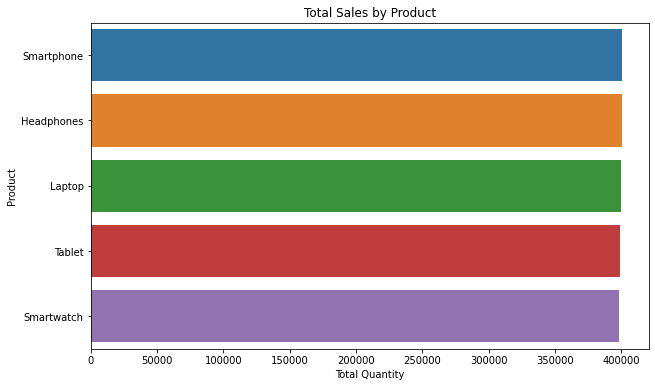

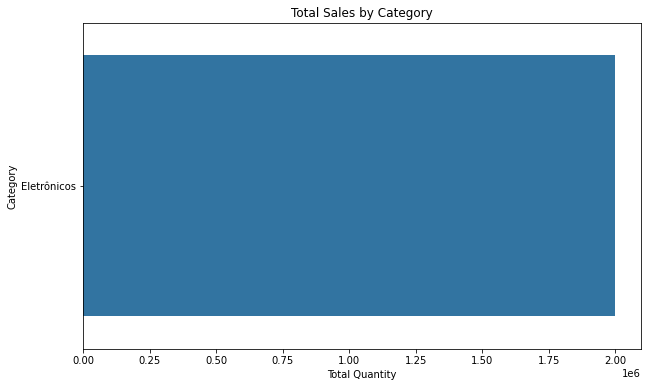

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total de vendas por produto
product_sales = spark.sql("""
    SELECT Product, SUM(Quantity) AS TotalQuantity
    FROM sales_data
    GROUP BY Product
    ORDER BY TotalQuantity DESC
""").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="TotalQuantity", y="Product", data=product_sales)
plt.xlabel("Total Quantity")
plt.ylabel("Product")
plt.title("Total Sales by Product")
plt.show()

# Total de vendas por categoria
category_sales = spark.sql("""
    SELECT Category, SUM(Quantity) AS TotalQuantity
    FROM sales_data
    GROUP BY Category
    ORDER BY TotalQuantity DESC
""").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="TotalQuantity", y="Category", data=category_sales)
plt.xlabel("Total Quantity")
plt.ylabel("Category")
plt.title("Total Sales by Category")
plt.show()
